# Check cleaned eeg data 

In [1]:
import itertools
import PyQt5
import numpy as np
import os
import pyxdf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import mne
import json
import glob
import re
from scipy import signal
import importlib
import multiprocessing as mp
import sys
import pyxdf
from asrpy import ASR
from utils.read_data import *

#from mne.preprocessing import ASR


In [2]:
DATA_PATH = './raw_data/'
PROCESSED_PATH = './processed_data/'

montage = "./ANT_EEG_channel_mapping.json"

os.makedirs(PROCESSED_PATH,  exist_ok=True)

In [3]:
trial_info = pd.read_csv(f'{PROCESSED_PATH}/trial_conditions.csv')

trial_info['raw_data_file'] = (
    DATA_PATH 
    + trial_info['subject_id'].astype(str) + '/' 
    + trial_info['subject_id'].astype(str) + '_' 
    + trial_info['block_id'].astype(str)
    + '.xdf'
)



def find_preprocessed_files(subject_id='', block_id='', save_dir=''):
#     D:\projects\GTI_decoding\code\paper\processed_data\M009\4\eeg\04_cleaned\block_4_eeg.fif
    clean_fname = glob.glob(os.path.join(save_dir,subject_id, str(block_id),"eeg/04_cleaned/*_eeg.fif"))
    epoched_fname = glob.glob(os.path.join(save_dir,subject_id, str(block_id),"eeg/03_epoched/*_epo.fif"))
    raw_epo_fname = glob.glob(os.path.join(save_dir,subject_id, str(block_id),"eeg/05_rawepochs/*_epo.fif"))
    
    if len(clean_fname)==0 or len(epoched_fname) == 0 or len(raw_epo_fname) == 0:
        return ['', '', '']
    
    return [clean_fname[0], epoched_fname[0], raw_epo_fname[0]]

for idx, row in trial_info.iterrows():
    trial_info.loc[idx, ['cleaned_data', 'epoched_data', 'raw_epochs']] = (
        find_preprocessed_files
        (row['subject_id'], 
         row['block_id'], 
         './processed_data/'
        )
    )
    
trial_info = trial_info.query('epoched_data !=""')

trial_info.trial_id = trial_info.trial_id - 1
trial_info.trial_id = trial_info.groupby('subject_id').trial_id.cumcount()

trial_info.shape

(6672, 14)

In [9]:
trial_info.head()

Unnamed: 0 subject_id  block_id  trial_id familiarity  task orientation  \
0           0       M006         1         0       unfam   use       right   
1           1       M006         1         1         fam   use       right   
2           2       M006         1         2         fam   use       right   
3           3       M006         1         3         fam  lift       right   
4           4       M006         1         4       unfam   use        left   

    tool_name  time        condition               raw_data_file  \
0  fishscaler   732  unfam/use/right  ./raw_data/M006/M006_1.xdf   
1  paintbrush   732    fam/use/right  ./raw_data/M006/M006_1.xdf   
2        fork   732    fam/use/right  ./raw_data/M006/M006_1.xdf   
3     spatula   732   fam/lift/right  ./raw_data/M006/M006_1.xdf   
4  fishscaler   732   unfam/use/left  ./raw_data/M006/M006_1.xdf   

                                        cleaned_data  \
0  ./processed_data/M006\1\eeg/04_cleaned\block_1...   
1  ./processed_data/M006\1\eeg/04_cleaned\block_1...   
2  ./processed_data/M006\1\eeg/04_cleaned\block_1...   
3  ./processed_data/M006\1\eeg/04_cleaned\block_1...   
4  ./processed_data/M006\1\eeg/04_cleaned\block_1...   

                                        epoched_data  \
0  ./processed_data/M006\1\eeg/03_epoched\block_1...   
1  ./processed_data/M006\1\eeg/03_epoched\block_1...   
2  ./processed_data/M006\1\eeg/03_epoched\block_1...   
3  ./processed_data/M006\1\eeg/03_epoched\block_1...   
4  ./processed_data/M006\1\eeg/03_epoched\block_1...   

                                          raw_epochs  
0  ./processed_data/M006\1\eeg/05_rawepochs\block...  
1  ./processed_data/M006\1\eeg/05_rawepochs\block...  
2  ./processed_data/M006\1\eeg/05_rawepochs\block...  
3  ./processed_data/M006\1\eeg/05_rawepochs\block...  
4  ./processed_data/M006\1\eeg/05_rawepochs\block...

In [6]:
subject_id = "M006"
block_id = 1
raw_files = trial_info.query('subject_id==@subject_id and block_id==@block_id').raw_data_file.unique()
raw_files

array(['./raw_data/M006/M006_1.xdf'], dtype=object)

In [109]:
data, header = pyxdf.load_xdf(raw_files[0])
stream = pd.Series(get_streams(data))

start_time = data[stream['eeg']]["time_stamps"][0]
eeg_time = data[stream['eeg']]["time_stamps"] - start_time  # get eeg time points

begin = int(np.searchsorted(
    data[stream['eeg']]["time_stamps"],
    data[stream['BaseLineBeginTimeStamp']]["time_stamps"][0]
))

end = int(np.searchsorted(
            data[stream['eeg']]["time_stamps"],
            data[stream['BaseLineEndTimeStamp']]["time_stamps"][0]
))

begin_time = data[stream['eeg']]["time_stamps"][begin] - start_time
end_time = data[stream['eeg']]["time_stamps"][end] - start_time

sr = data[stream['eeg']]['info']['effective_srate']  # sampling rate of eeg

n_ch = int(data[stream['eeg']]['info']['channel_count'][0])  # no. of eeg channels

ch_typ = ['eeg'] * 64 + ['eog'] + ['misc']*7 # set channel type for mne

ch_names = get_channel_names(
    data[stream['eeg']]['info']['desc'][0]['channels'][0]['channel'],
    n_ch,
    montage
)

# map the trial start cue i.e. the first index in the event_streams to ecent array for mne
tdf = trial_info.query('subject_id==@subject_id and block_id==@block_id')
# print(tdf)
trial_event_map = {t:i+1 for i,t in enumerate(trial_info.condition.unique())}

tdf['int_cond'] = tdf.condition.map(trial_event_map)
# print(tdf)
# find events timestamps within eeg data stream
x = np.searchsorted(
    data[stream['eeg']]["time_stamps"],
    data[stream['ObjectShownTimeStamp']]["time_stamps"]
)
# print(x.shape,)


event_trial_start = np.zeros((x.shape[0], 3), dtype=int)
event_trial_start[:, 0] = x
event_trial_start[:, 2] = tdf.int_cond.values #.to_numpy(dtype=int)

# del trial_info, tdf
# gc.collect()

# create mne info
info = mne.create_info(ch_names, ch_types=ch_typ, sfreq=sr)

# mne data array should be in (nChannel,nSamples) whereas xdf stores in (nSamples,nChannel)
eeg = mne.io.RawArray(np.transpose(data[stream['eeg']]["time_series"]), info)

# drop auxiliaries and not needed channels
eeg.drop_channels(['BIP66', 'BIP67', 'BIP68', 'AUX69', 'AUX70', 'AUX71', 'AUX72'])

# eeg.rename_channels({'BIP65': 'EOG'})

# eeg.set_

# set the montage
eeg.set_montage('standard_1020')

eeg.crop(tmin=15)
eeg_resamp, events_resamp = eeg.resample(sfreq=256, events=event_trial_start)

del eeg
# EEG is recorded with average reference. Re-refer to Cz
eeg_resamp.set_eeg_reference(ref_channels=['Cz'])
eeg_resamp.filter(l_freq=2, h_freq=120, h_trans_bandwidth=1.0, verbose=False)
eeg_resamp.notch_filter(freqs=[16.67, 50, 100], verbose=False)

# epochs paramaters
tmin = -0.1  # 100 msec before the event boundary
tmax = 3.1  # each trial is 2.0 + 0.5 + 3.0 + 0.5...NOTE: first 0.5 sec of action is included
baseline = (tmin, 0)  # i.e. the entire zone from tmin to 0
epochs = mne.Epochs(eeg_resamp, events_resamp, event_id=trial_event_map, tmin=tmin, tmax=tmax)
epochs.drop_bad()

C:\Users\akeshava\AppData\Local\Temp\ipykernel_8648\3725902638.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['int_cond'] = tdf.condition.map(trial_event_map)


Creating RawArray with float64 data, n_channels=72, n_times=999936
    Range : 0 ... 999935 =      0.000 ...   976.499 secs
Ready.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
48 matching events found
Setting baseline interval to [-0.1015625, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 821 original time points ...
0 bad epochs dropped


<Epochs |  48 events (all good), -0.101562 – 3.10156 s, baseline -0.101562 – 0 s, ~77 kB, data not loaded,
 'unfam/use/right': 6
 'fam/use/right': 6
 'fam/lift/right': 6
 'unfam/use/left': 6
 'fam/lift/left': 6
 'unfam/lift/left': 6
 'unfam/lift/right': 6
 'fam/use/left': 6>

In [74]:
%matplotlib qt
eeg_resamp.plot(duration=60, n_channels=64, scalings='auto',show_options=True);

Channels marked as bad:
none


In [75]:
asr_baseline = eeg_resamp.copy()
# asr = ASR(sfreq=eeg_resamp.info["sfreq"], cutoff=15)
asr_baseline.crop(tmin=begin_time+0.5, tmax=end_time)
asr_baseline.plot(n_channels=20, scalings='auto',show_options=True);


Channels marked as bad:
none


Using EOG channel: BIP65
EOG channel index for this subject is: [64]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel BIP65 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 344 significant peaks
Number of EOG events detected: 344
Not setting metadata
344 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 344 events and 257 original time points ...
0 bad epochs dropped
Not setting me

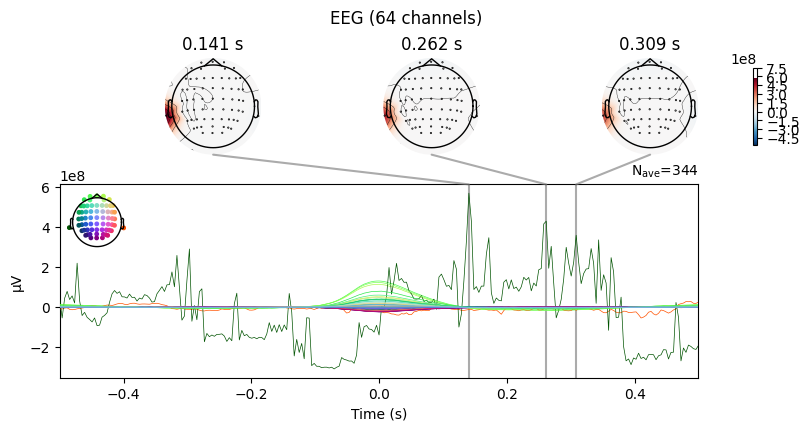

In [105]:
eog_epochs = mne.preprocessing.create_eog_epochs(eeg_resamp, baseline=(-0.5, -0.2))
eog_epochs.plot_image(combine="mean")
eog_epochs.average().plot_joint()

In [106]:
ica = mne.preprocessing.ICA(n_components=64, max_iter="auto", random_state=97)
ica.fit(epochs)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Using data from preloaded Raw for 48 events and 821 original time points ...


C:\Users\akeshava\AppData\Local\Temp\ipykernel_8648\2292553592.py:2: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Selecting by number: 64 components
Using data from preloaded Raw for 48 events and 821 original time points ...
Fitting ICA took 5.2s.


C:\Users\akeshava\AppData\Local\Temp\ipykernel_8648\2292553592.py:2: RuntimeWarning: Using n_components=64 (resulting in n_components_=64) may lead to an unstable mixing matrix estimation because the ratio between the largest (61) and smallest (1.6e-34) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 61
  ica.fit(epochs)


<ICA | epochs decomposition, method: fastica (fit in 102 iterations on 39408 samples), 64 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

In [108]:
ica.plot_components(inst=epochs);

In [111]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(eeg_resamp)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
ica.plot_properties(eeg_resamp, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(eeg_resamp, show_scrollbars=False)

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_evoked)

Using EOG channel: BIP65
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=65, n_times=246144
    Range : 3840 ... 249983 =     15.000 ... 

NameError: name 'eog_evoked' is not defined

In [84]:
clean_epochs.get_data().shape

C:\Users\akeshava\AppData\Local\Temp\ipykernel_6744\2447023153.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  clean_epochs.get_data().shape


(288, 64, 821)

In [72]:
clean_epochs.detrend=0

In [4]:
epochs_list=[]
for ep in trial_info.query('subject_id == "M006" and block_id in [1,2]').epoched_data.unique():
    print(f"*********{ep}***********")
    epochs_list.append(mne.read_epochs(ep, verbose=False))
clean_epochs = mne.concatenate_epochs(epochs_list)

*********./processed_data/M006\1\eeg/03_epoched\block_1_epo.fif***********
*********./processed_data/M006\2\eeg/03_epoched\block_2_epo.fif***********
Not setting metadata
96 matching events found
No baseline correction applied


In [5]:
epochs_list=[]
for ep in trial_info.query('subject_id == "M006" and block_id in [1,2]').raw_epochs.unique():
    print(f"*********{ep}***********")
    epochs_list.append(mne.read_epochs(ep, verbose=False))
unclean_epochs = mne.concatenate_epochs(epochs_list)

*********./processed_data/M006\1\eeg/05_rawepochs\block_1_epo.fif***********
*********./processed_data/M006\2\eeg/05_rawepochs\block_2_epo.fif***********
Not setting metadata
96 matching events found
No baseline correction applied


In [30]:
clean_epochs = clean_epochs.apply_baseline((-0.1, 0))
unclean_epochs = unclean_epochs.apply_baseline((-0.1, 0))

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


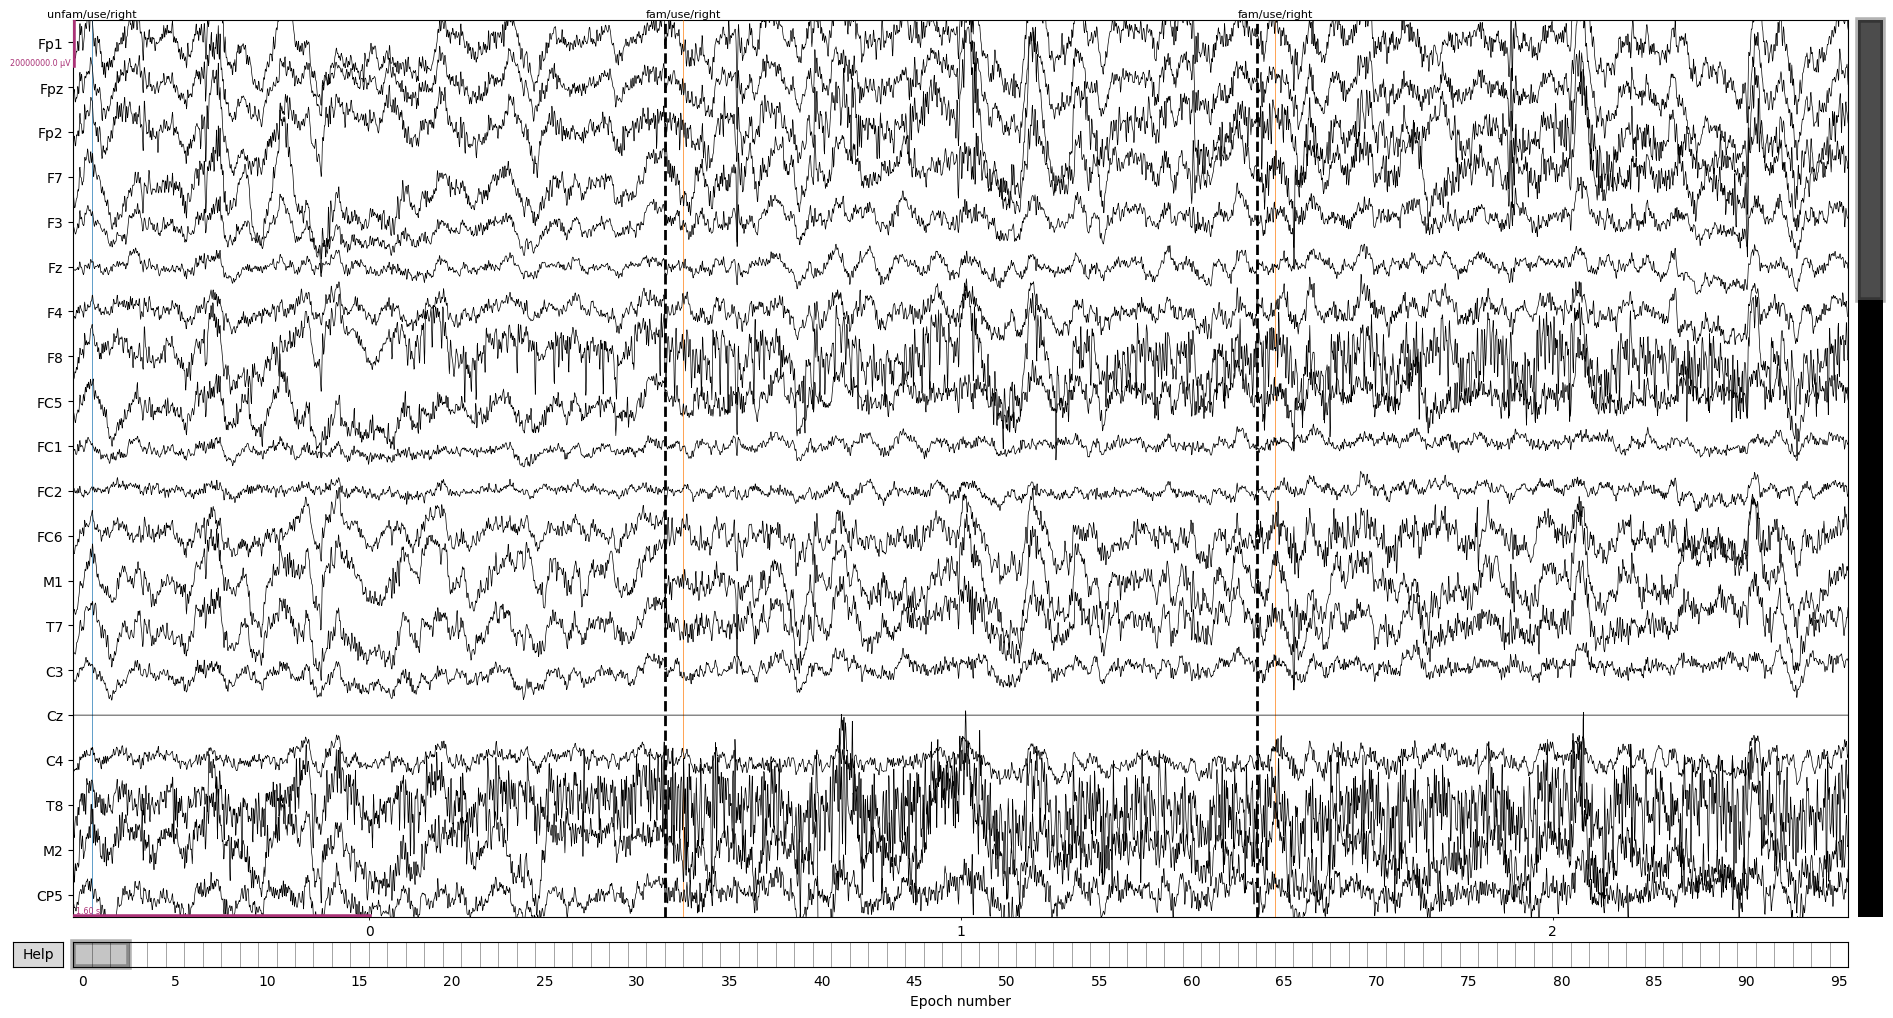

In [33]:
# % matplotlib qt5
clean_epochs.plot(n_epochs=3,
            scalings=10,
            events=clean_epochs.events,
            event_id=clean_epochs.event_id,);


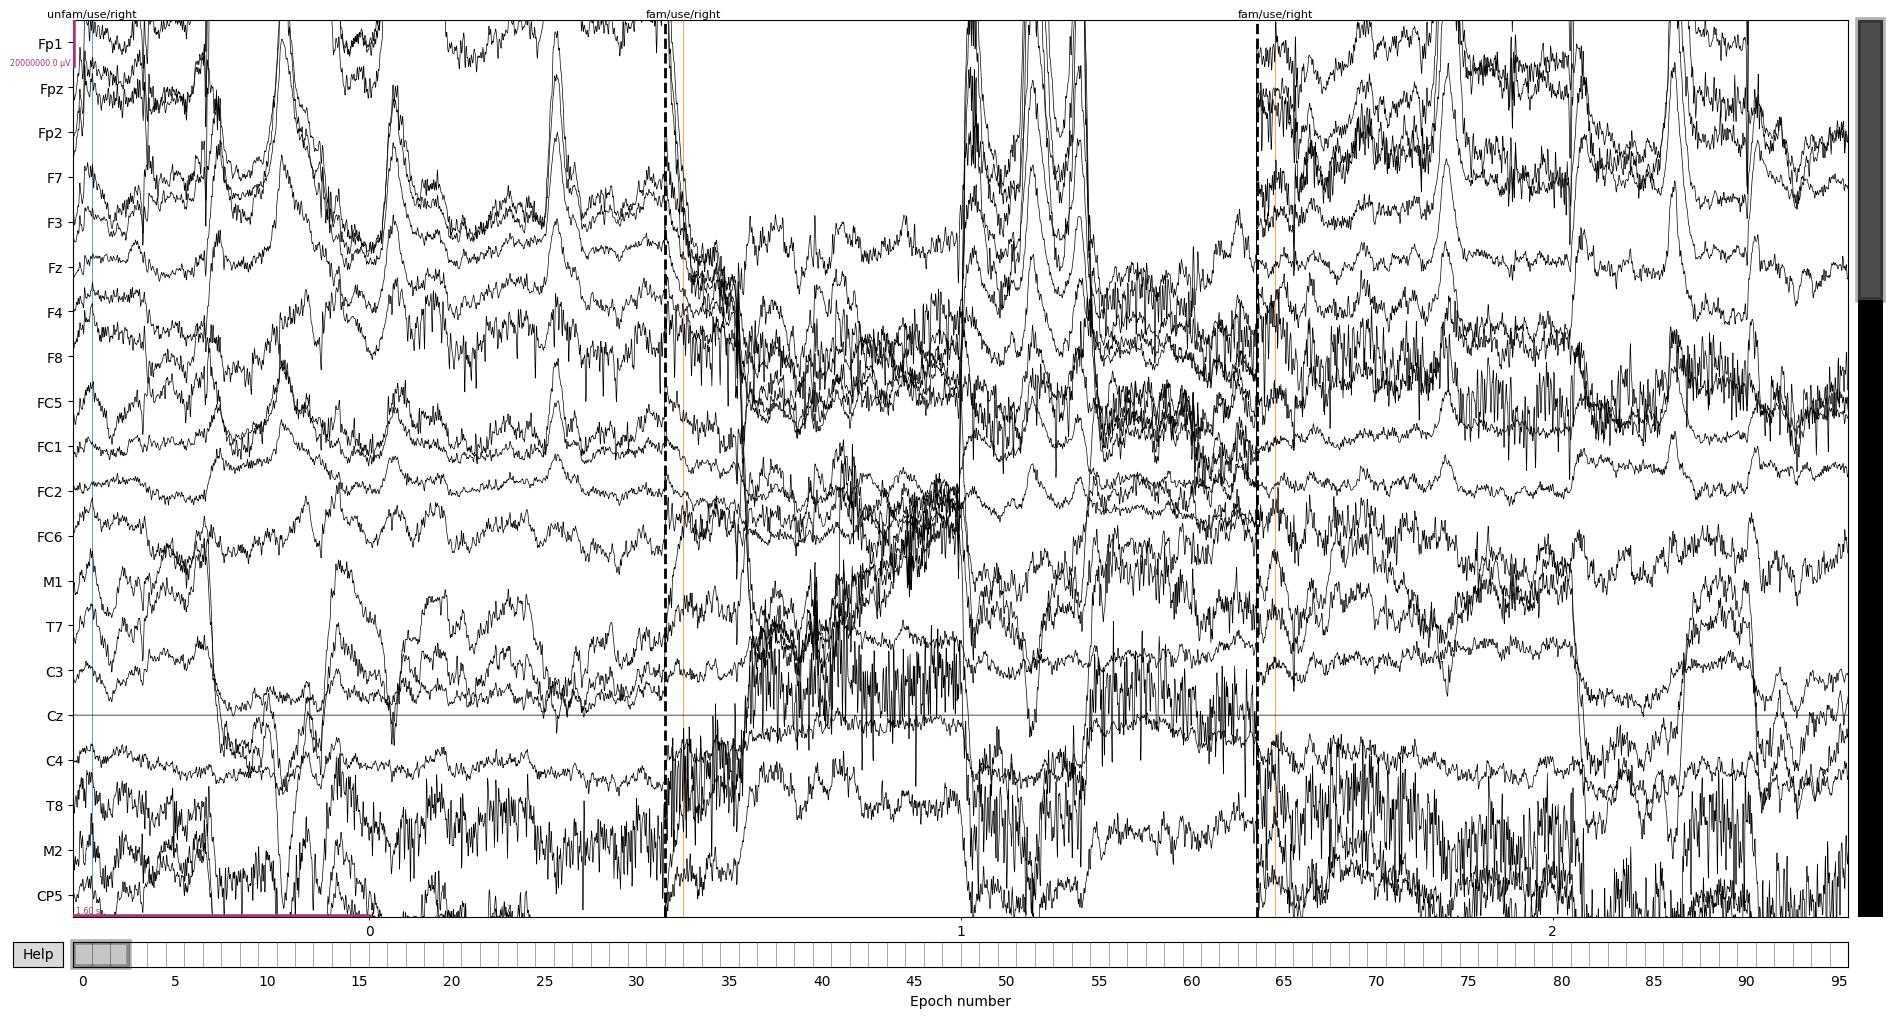

In [34]:
unclean_epochs.plot(n_epochs=3,
            scalings=10,
            events=unclean_epochs.events,
            event_id=unclean_epochs.event_id,);

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\akeshava\.conda\envs\gti_mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


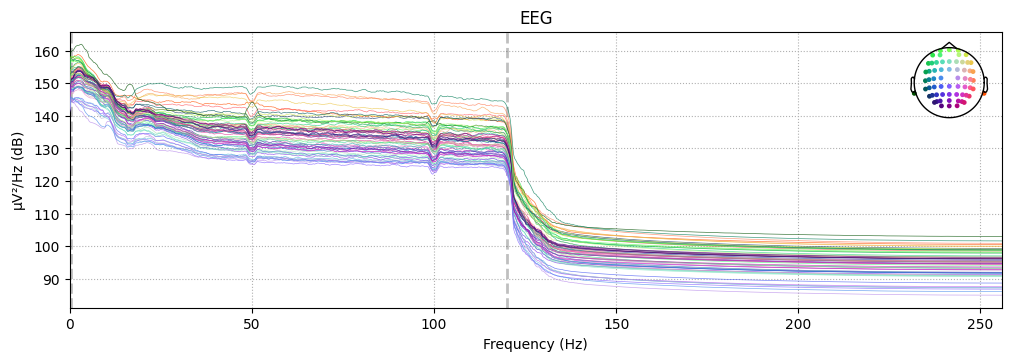

In [35]:
# _, ax=plt.subplots(figsize=(10, 6))

clean_epochs.compute_psd(remove_dc=True, exclude=['Cz']).plot(picks='data')

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\akeshava\.conda\envs\gti_mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


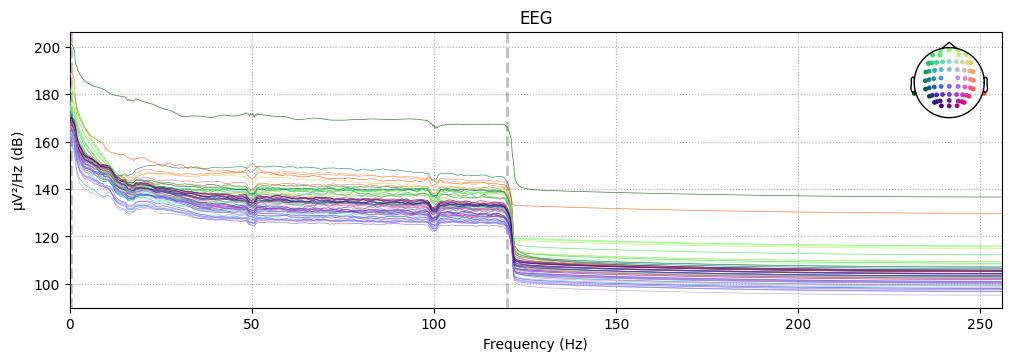

In [36]:
unclean_epochs.compute_psd(remove_dc=True, exclude=['Cz']).plot(picks='data')

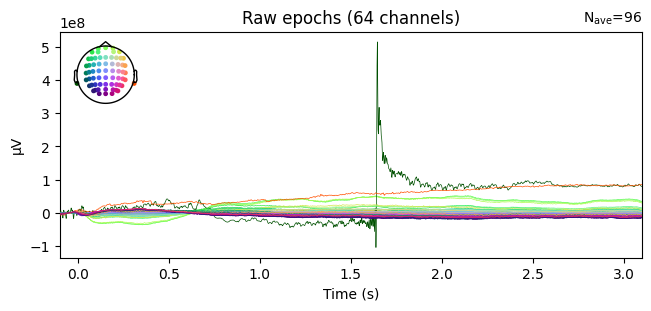

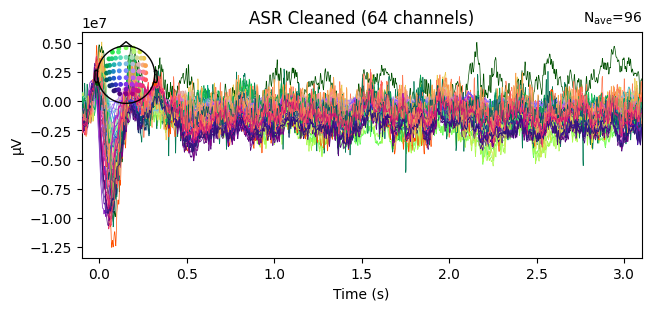

In [38]:
unclean_epochs.average().plot(
            spatial_colors=True, 
            titles="Raw epochs"
        );

clean_epochs.average().plot(
            spatial_colors=True, 
            titles="ASR Cleaned"
        );

Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


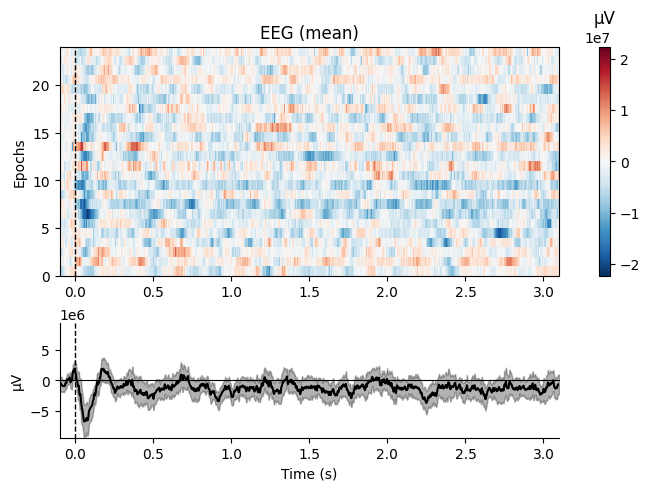

[<Figure size 640x480 with 3 Axes>]

In [41]:
%matplotlib inline

clean_epochs["use/unfam"].plot_image(combine="mean", show=True)
# plt.show()

Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


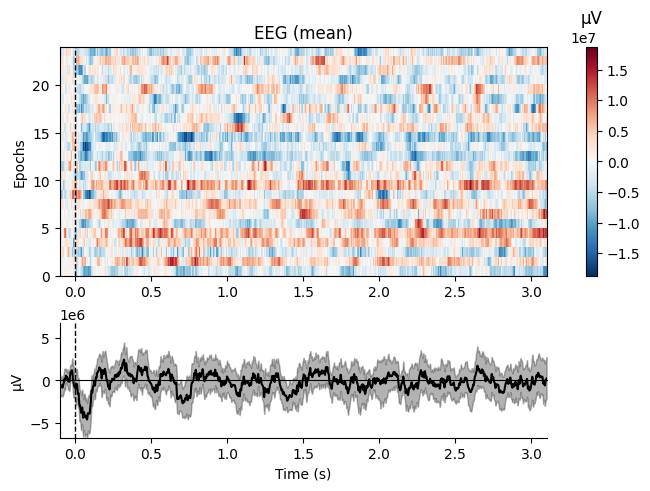

[<Figure size 640x480 with 3 Axes>]

In [42]:
%matplotlib inline

clean_epochs["lift/fam"].plot_image(combine="mean", show=True)
# plt.show()

C:\Users\akeshava\AppData\Local\Temp\ipykernel_8704\1540922802.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


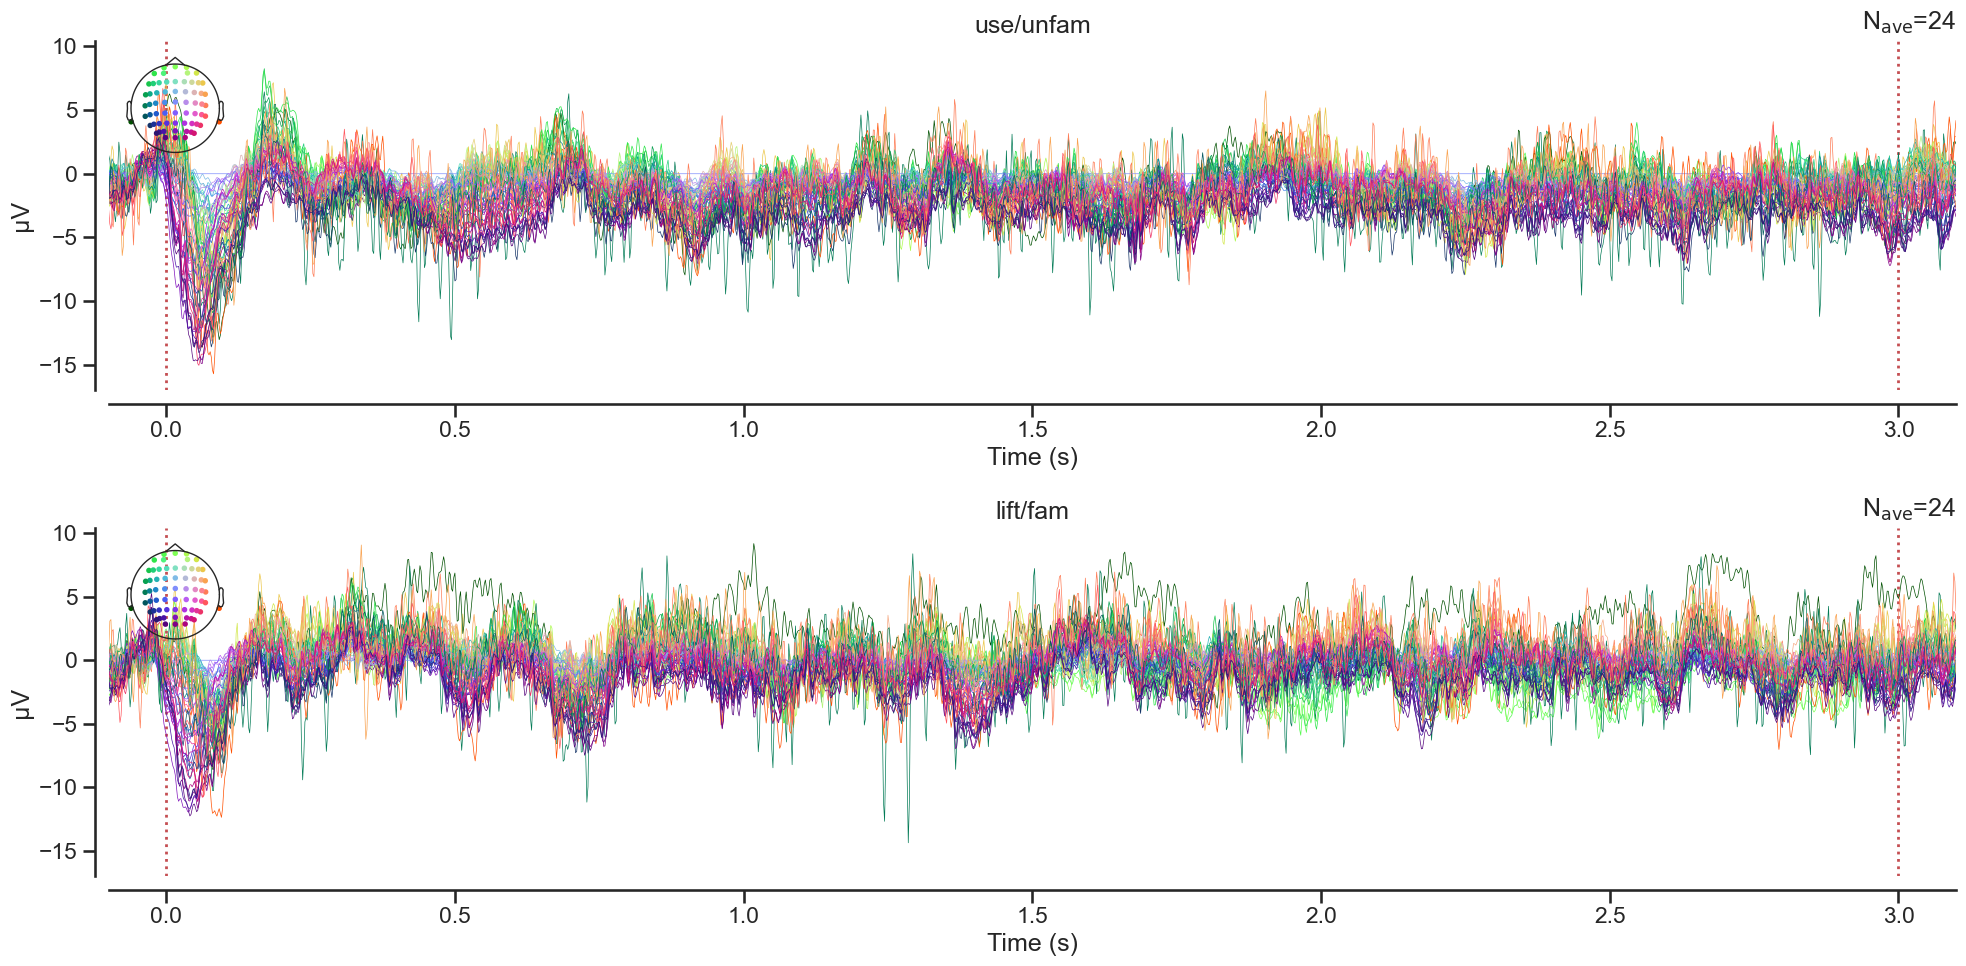

In [44]:
## numpy_epochs_lift has shape epochs x channels x times
## numpy_epochs_use has shape epochs x channels x times
info = clean_epochs.info
# lift_epochs = mne.EpochsArray(clean_epochs['lift'].get_data()  )
# use_epochs = mne.EpochsArray(clean_epochs['use'].get_data())


task_evoked_lift = clean_epochs['use/unfam'].average() 
task_evoked_use = clean_epochs['lift/fam'].average()

sns.set(context='talk', style='ticks')
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharey=True)

plt.subplots_adjust(hspace=0.5)


ax[0].axvline(0, ls=':', lw=2, color='r')
ax[0].axvline(3., ls=':', lw=2, color='r')



ax[1].axvline(0, ls=':', lw=2, color='r')
ax[1].axvline(3, ls=':', lw=2, color='r')


task_evoked_lift.plot( axes=ax[0], spatial_colors=True, scalings=1, show=False)
task_evoked_use.plot( axes=ax[1], spatial_colors=True, scalings=1, show=False)

ax[0].set(
    title='use/unfam',
    # ylim=(-6,6)
)
ax[1].set(
    title='lift/fam',
    # ylim=(-6,6)
)

sns.despine(offset=10)
fig.tight_layout()